# Projet Modèle Linéaire
## Antoine Legendre

### 1 : Prise en main du jeu de données

#### 1.1 : Chargement du jeu de données

In [1]:
# Import de toutes les librairies
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sma
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, r2_score
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl
from sklearn.neighbors import BallTree
import numpy as np

# Charger le dataset
data = fetch_california_housing()
# Convertir les données en DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target  # Ajouter la cible (prix médian des maisons) en tant que colonne

# Exporter vers un fichier CSV afin de pouvoir visualiser des données
df.to_csv("california_housing.csv", index=False)

#### 1.2 : Statistiques Descriptives

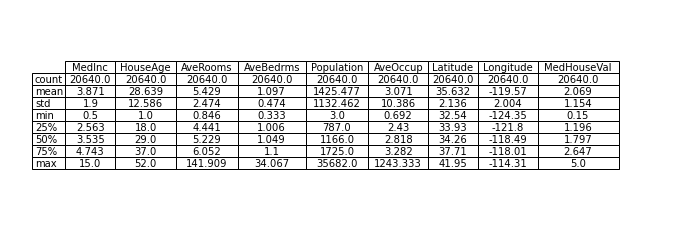

In [2]:
# Affichage des statistiques descriptives dans un tableau

# Calculer les statistiques descriptives
stats = df.describe().round(3) # On conserve seulement 3 chiffres après la virgule pour plus de lisibilité

fig, ax = plt.subplots(figsize=(12, 4)) 
ax.axis('off') 

# Ajouter une table des statistiques au graphique
table = ax.table(
    cellText=stats.values,
    colLabels=stats.columns,
    rowLabels=stats.index,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(stats.columns))))

plt.show()

#### 1.3 : Prix médian des logements en fonction de chaque variable

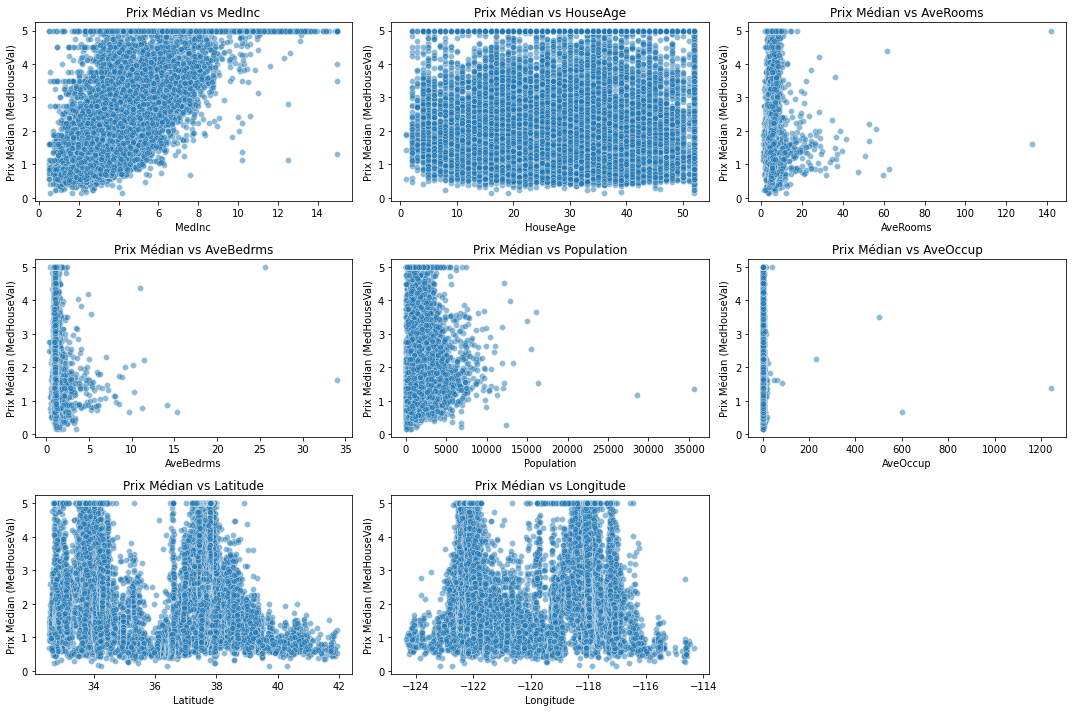

In [3]:
# Graphiques afin de visualiser la répartition des prix médians des maisons en fonction de chaque variable

plt.figure(figsize=(15, 10))

# Boucle pour créer un graphique pour chaque variable
for i, column in enumerate(df.columns[:-1], 1):  # Exclure MedHouseVal 
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df, x=column, y="MedHouseVal", alpha=0.5)
    plt.title(f"Prix Médian vs {column}")
    plt.xlabel(column)
    plt.ylabel("Prix Médian (MedHouseVal)")

plt.tight_layout()
plt.show()

#### 1.4 : Matrice de covariance

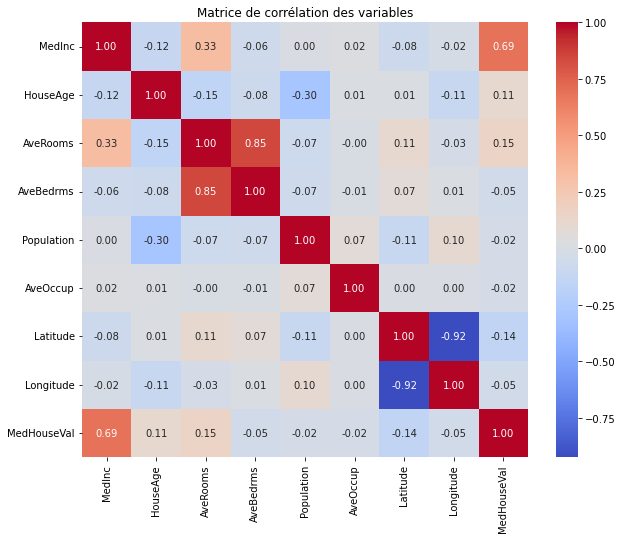

In [4]:
# Matrice de corrélation

correlation_matrix = df.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des variables")

plt.show()

### 2 : Modèles prédictifs

#### 2.1 : Premier modèle prédictif à l’aide du critère AIC

In [5]:
# Calcul d'un bon modèle prédictif à l'aide du critère AIC qui va nous permettre de sélectionner les covariables expliquant le mieux le prix médian des maisons

# Séparer les covariables et la cible
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal']

# Standardiser les données explicatives
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Fonction pour la sélection progressive selon le critère AIC
def stepwise_selection(X, y, verbose=True):
    remaining = list(X.columns)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            # Modèle avec les variables sélectionnées et une nouvelle variable candidate
            model = sma.OLS(y, sma.add_constant(X[selected + [candidate]])).fit()
            scores_with_candidates.append((model.aic, candidate))

        # Trier les scores AIC et choisir le meilleur candidat
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop(0)

        # Mise à jour si l'AIC s'améliore
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            if verbose:
                print(f"Ajouté : {best_candidate}, AIC : {current_score}")
        else:
            break

    # Finaliser avec le modèle optimal
    final_model = sma.OLS(y, sma.add_constant(X[selected])).fit()
    return selected, final_model

# Appliquer la sélection progressive sur les données standardisées
selected_features, final_model = stepwise_selection(X_scaled, y)

# Résultats
print("\nVariables sélectionnées :", selected_features)
print("\nRésumé du modèle final :")
print(final_model.summary())

Ajouté : MedInc, AIC : 51249.33766328358
Ajouté : HouseAge, AIC : 49803.43086359236
Ajouté : Latitude, AIC : 49463.15910098319
Ajouté : Longitude, AIC : 45887.707294155705
Ajouté : AveBedrms, AIC : 45643.57513109551
Ajouté : AveRooms, AIC : 45323.97536705191
Ajouté : AveOccup, AIC : 45264.24293611405

Variables sélectionnées : ['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']

Résumé du modèle final :
                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     4538.
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:09:30   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.526e+04
Df Resi

In [6]:
# Estimation du R² ajusté par validation croisée afin de voir s'il y a eu du sur-apprentissage

# Obtenir les indices des colonnes sélectionnées
selected_indices = [X.columns.get_loc(col) for col in selected_features]

# Modèle final avec les colonnes sélectionnées
final_model = LinearRegression()
X_selected = X_scaled.iloc[:, selected_indices]
scores = cross_val_score(final_model, X_selected, y, cv=5, scoring=make_scorer(r2_score))

print(f"R² ajusté par validation croisée : {scores.mean()}")

R² ajusté par validation croisée : 0.5539063771113042


#### 2.2 : Nouvelles variables

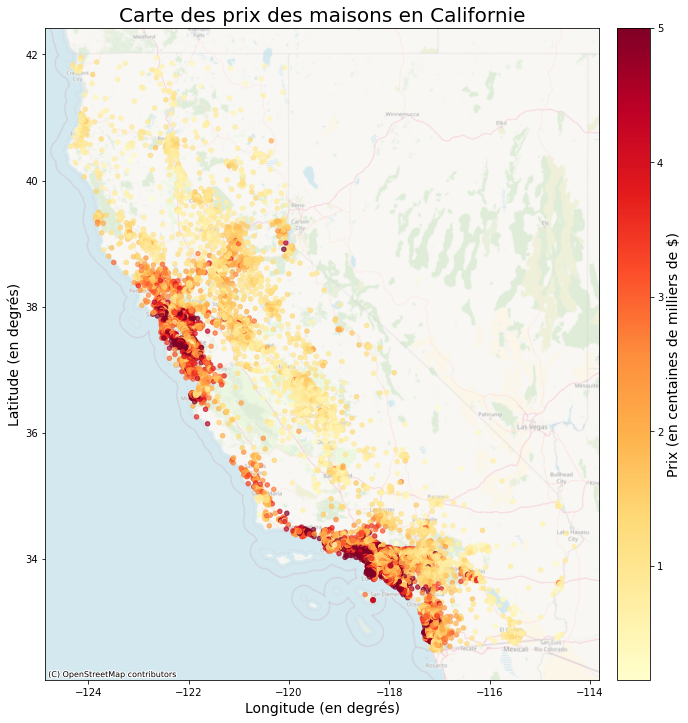

In [7]:
# Réalisation d'une carte qui va permettre de visualiser la répartition géographique des blocs et des prix médians des maisons (à l'aide du code couleur)

# Convertir les données en GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Définir le système de coordonnées 
geo_df.set_crs(epsg=4326, inplace=True)

# Créer le graphique
fig, ax = plt.subplots(figsize=(16, 12))

# Tracer les points (données originales en degrés)
geo_df.plot(
    ax=ax,
    column='MedHouseVal',
    cmap='YlOrRd',
    markersize=20, 
    alpha=0.7
)

# Fond de carte projeté
ctx.add_basemap(ax, crs=geo_df.crs, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

# Barre de couleurs
norm = mpl.colors.Normalize(vmin=geo_df['MedHouseVal'].min(), vmax=geo_df['MedHouseVal'].max())
sm = mpl.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])

# Ajout de la barre de couleurs à côté de l'axe
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
cbar.set_label("Prix (en centaines de milliers de $)", fontsize=14)

# Titres des axes et titre principal
ax.set_xlabel("Longitude (en degrés)", fontsize=14)
ax.set_ylabel("Latitude (en degrés)", fontsize=14)
ax.set_title("Carte des prix des maisons en Californie", fontsize=20)

plt.show()

In [8]:
# Remplacement des covariables longitude et latitude par une variable de moyenne des prix médians dans un rayon de x km autour de chaque bloc (ce bloc exclu)

# Rayon en kilomètres
radii = [1, 2, 5, 10, 100]  # Différents rayons pour calculer les moyennes
earth_radius = 6371.0

# Conversion des latitudes et longitudes en radians
lat_long_rad = np.deg2rad(df[['Latitude', 'Longitude']].to_numpy())

# Construction de BallTree
tree = BallTree(lat_long_rad, metric='haversine')

# Fonction pour calculer la moyenne des prix des voisins dans un rayon donné
def compute_avg_price_balltree(tree, lat_long_rad, prices, radius, earth_radius):
    radius_in_radians = radius / earth_radius
    avg_prices = []

    for i, point in enumerate(lat_long_rad):
        indices = tree.query_radius([point], r=radius_in_radians)[0]
        indices = indices[indices != i]  # Exclure le bloc lui-même
        if len(indices) > 0:
            avg_prices.append(prices[indices].mean())
        else:
            avg_prices.append(np.nan)  # Aucun voisin trouvé
    return avg_prices

# Création des nouvelles covariables pour chaque rayon
for radius in radii:
    df[f'AvgPriceRadius_{radius}km'] = compute_avg_price_balltree(
        tree, lat_long_rad, df['MedHouseVal'].values, radius, earth_radius
    )

# Gestion des valeurs manquantes
df.fillna(df.mean(), inplace=True)

# Exporter vers un fichier CSV pour inclure les nouvelles colonnes
df.to_csv("california_housing_with_radius.csv", index=False)

#### 2.3 : Régressions Ridge et Lasso

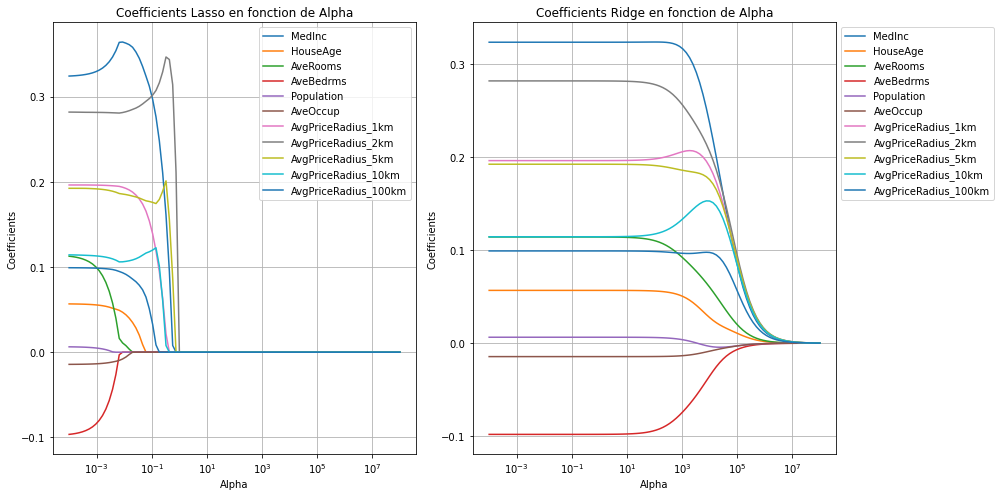

In [9]:
# Graphique montrant l'évolution des coefficients des covariables pour des régressions Lasso et Ridge en fonction de leur coefficient de pénalisation alpha

# Variables explicatives
X = df.drop(columns=['MedHouseVal', 'Latitude', 'Longitude'])

# Standardiser les données
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Plages de valeurs d'alpha à tester (en log)
alphas = np.logspace(-4, 8, 100)

# Initialiser les modèles Lasso et Ridge
lasso = Lasso()
ridge = Ridge()

# Initialiser les listes pour stocker les coefficients
lasso_coefs = []
ridge_coefs = []

# Calcul des coefficients pour différentes valeurs de alpha
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    ridge.set_params(alpha=alpha)
    
    # Ajuster les modèles
    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    
    # Stocker les coefficients
    lasso_coefs.append(lasso.coef_)
    ridge_coefs.append(ridge.coef_)

# Convertir les listes en tableaux numpy pour les rendre plus faciles à manipuler
lasso_coefs = np.array(lasso_coefs)
ridge_coefs = np.array(ridge_coefs)

plt.figure(figsize=(14, 7))

# Subplot pour Lasso
plt.subplot(1, 2, 1)
for i in range(lasso_coefs.shape[1]):
    plt.plot(alphas, lasso_coefs[:, i], label=X.columns[i])  # Utilisation des noms des colonnes de X
plt.xscale('log') # Échelle logarithmique pour alpha
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Coefficients Lasso en fonction de Alpha')
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(1, 1))

# Subplot pour Ridge
plt.subplot(1, 2, 2)
for i in range(ridge_coefs.shape[1]):
    plt.plot(alphas, ridge_coefs[:, i], label=X.columns[i])  # Utilisation des noms des colonnes de X
plt.xscale('log')  # Échelle logarithmique pour alpha
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Coefficients Ridge en fonction de Alpha')
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(1, 1)) 

plt.tight_layout()
plt.show()

In [10]:
# Régressions Lasso et Ridge pour le nouveau modèle prédictif avec des covariables AvgPriceRadius_xkm

# Modèles avec pénalisation (On choisit les critères de pénalisation alpha en fonction des graphiques précédents et de ce que l'on veut observer)
models = {
    "Lasso": Lasso(alpha=0.1, random_state=42), # Ce choix va nous permettre d'annuler des coefficients et donc d'obtenir un modèle plus simple mais toujours précis
    "Ridge": Ridge(alpha=100, random_state=42) 
}

coefficients = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Entraînement sur le jeu d'entraînement
    model_coefficients = pd.Series(model.coef_, index=df.drop(columns=['MedHouseVal', 'Latitude', 'Longitude']).columns, name=name)
    intercept = model.intercept_  # Récupération de l'intercept
    model_coefficients["Intercept"] = intercept  # Ajout de l'intercept aux coefficients
    coefficients[name] = model_coefficients

# Comparaison des coefficients
coefficients_comparison = pd.concat(coefficients.values(), axis=1)

# Afficher les coefficients
print(coefficients_comparison)

                         Lasso     Ridge
MedInc                0.301080  0.323725
HouseAge              0.000000  0.056130
AveRooms              0.000000  0.110255
AveBedrms            -0.000000 -0.093887
Population           -0.000000  0.006138
AveOccup             -0.000000 -0.014302
AvgPriceRadius_1km    0.143176  0.198062
AvgPriceRadius_2km    0.300650  0.278134
AvgPriceRadius_5km    0.176129  0.191010
AvgPriceRadius_10km   0.119336  0.117332
AvgPriceRadius_100km  0.037689  0.098652
Intercept             2.068584  2.068203


In [11]:
# Calcul du R² et du R² ajusté par validation croisée pour les régressions Lasso et Ridge

# Entraînement et évaluation sur le test set
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"{name} : R² : {test_score}")


# Validation croisée pour chaque modèle
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    print(f"{name} : R² ajusté par validation croisée : {scores.mean()}")

Lasso : R² : 0.8000273123383559
Ridge : R² : 0.8120487229659666
Lasso : R² ajusté par validation croisée : 0.7961168573811414
Ridge : R² ajusté par validation croisée : 0.811689858248501


#### 2.4 : Nouveau modèle prédictif à l’aide du critère AIC

In [12]:
# Détermination du meilleur modèle prédictif au sens du critère AIC

# Conversion en DataFrame
X_scaled_df = pd.DataFrame((X_scaled), columns=X.columns)

# Appliquer la sélection progressive sur les données standardisées
selected_features, final_model = stepwise_selection(X_scaled_df, y)

# Résultats
print("\nVariables sélectionnées :", selected_features)
print("\nRésumé du modèle final :")
print(final_model.summary())

Ajouté : AvgPriceRadius_2km, AIC : 39496.90300601508
Ajouté : MedInc, AIC : 33929.126362237585
Ajouté : AvgPriceRadius_10km, AIC : 31363.133524010536
Ajouté : AvgPriceRadius_1km, AIC : 30824.97840025457
Ajouté : AvgPriceRadius_100km, AIC : 30492.550511427355
Ajouté : AvgPriceRadius_5km, AIC : 30305.529550834894
Ajouté : HouseAge, AIC : 30105.43723253077
Ajouté : AveOccup, AIC : 30086.23603145161
Ajouté : AveRooms, AIC : 30070.684453862872
Ajouté : AveBedrms, AIC : 29974.782870394276
Ajouté : Population, AIC : 29972.543098920374

Variables sélectionnées : ['AvgPriceRadius_2km', 'MedInc', 'AvgPriceRadius_10km', 'AvgPriceRadius_1km', 'AvgPriceRadius_100km', 'AvgPriceRadius_5km', 'HouseAge', 'AveOccup', 'AveRooms', 'AveBedrms', 'Population']

Résumé du modèle final :
                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:             

In [13]:
# Estimation du R² ajusté par validation croisée afin de voir s'il y a eu du sur-apprentissage

# Obtenir les indices des colonnes sélectionnées
selected_indices = [X.columns.get_loc(col) for col in selected_features]

# Modèle final avec les colonnes sélectionnées
final_model = LinearRegression()
X_selected = X_scaled[:, selected_indices]
scores = cross_val_score(final_model, X_selected, y, cv=5, scoring=make_scorer(r2_score))

print(f"R² ajusté par validation croisée : {scores.mean()}")

R² ajusté par validation croisée : 0.7968145013921994


#### 2.5 : Implémentation des modèles

In [14]:
# Ajustement des coefficients et de l'intercept standardisés

# Initialisation des dictionnaires
standardized_intercept = {}
standardized_coefficients = {}
original_coefficients = {}
original_intercept = {}

# Moyennes et écarts-types des covariables
means = X.mean(axis=0)  
stds = X.std(axis=0)   

# Traitement pour chaque modèle
for model_name, coef_series in coefficients.items():
    # Extraire les coefficients et l'intercept
    intercept = coef_series['Intercept']
    coef_without_intercept = coef_series.drop('Intercept')

    # Enregistrer les coefficients standardisés et l'intercept
    standardized_coefficients[model_name] = coef_without_intercept.to_numpy()
    standardized_intercept[model_name] = intercept

    # Calculer les coefficients originaux
    original_coefficients[model_name] = standardized_coefficients[model_name] / stds
    original_intercept[model_name] = standardized_intercept[model_name] - np.sum(
        (standardized_coefficients[model_name] * means) / stds
    )    

In [15]:
# Prédiction du prix médian des maisons avec les coefficients trouvés avec la régression Ridge (modèle plus précis)

# Récupérer les noms des colonnes des covariables
column_names = df.drop(columns=['MedHouseVal', 'Latitude', 'Longitude']).columns  # Adapter en fonction de vos colonnes

# Prédiction avec des valeurs non standardisées
def predict_house_price_ridge(input_values):
    # Convertir les entrées utilisateur en un numpy array ordonné selon l'ordre des covariables
    input_array = np.array([input_values[col] for col in column_names])
    
    # Calcul de la prédiction
    predicted_value = np.dot(original_coefficients['Ridge'], input_array) + original_intercept['Ridge']
    return predicted_value

# Exemple d'utilisation (avec le premier bloc du dataset)
input_values = {
    "MedInc": 8.3252, # Rentrez le revenu médian du bloc dont vous souhaitez prédire le prix médian des maisons
    "HouseAge": 41.0, # Age médian des logements du bloc
    "AveRooms": 6.984126984126984, # Nombre moyen de pièces par ménage 
    "AveBedrms": 1.0238095238095237, # Nombre moyen de chambres par ménage
    "Population": 322.0, # Population du bloc
    "AveOccup": 2.5555555555555554, # Nombre moyen de personnes par ménage
    # Prix médian des logements des blocs situés à moins d'xkm du bloc étudié (en centaines de milliers de dollars)
    "AvgPriceRadius_1km": 4.75,
    "AvgPriceRadius_2km": 4.75,
    "AvgPriceRadius_5km": 2.953818595041322,
    "AvgPriceRadius_10km": 2.4368399498746864,
    "AvgPriceRadius_100km": 2.470687346978941
}

# Calcul du prix prédit
predicted_price = predict_house_price_ridge(input_values)
print(f"Prix prédit de la maison : {predicted_price:.3f} (en centaines de milliers de dollars)")

Prix prédit de la maison : 4.608 (en centaines de milliers de dollars)


In [16]:
# Prédiction du prix médian des maisons avec les coefficients trouvés avec la régression Lasso (modèle plus simple)

# Prédiction avec des valeurs non standardisées
def predict_house_price_lasso(input_values):
    # Convertir les entrées utilisateur en un numpy array ordonné selon l'ordre des covariables
    input_array = np.array([input_values[col] for col in column_names])
    
    # Calcul de la prédiction
    predicted_value = np.dot(original_coefficients['Lasso'], input_array) + original_intercept['Lasso']
    return predicted_value

# Exemple d'utilisation (avec le premier bloc du dataset)
input_values = {
    "MedInc": 8.3252,  # Rentrez le revenu médian du bloc dont vous souhaitez prédire le prix médian des maisons
    # Coefficients nuls pour la régression Lasso, pas besoin de rentrer de valeurs
    "HouseAge": 0, 
    "AveRooms": 0, 
    "AveBedrms": 0, 
    "Population": 0, 
    "AveOccup": 0, 
    # Prix médian des logements des blocs situés à moins d'xkm du bloc étudié (en centaines de milliers de dollars)
    "AvgPriceRadius_1km": 4.75,
    "AvgPriceRadius_2km": 4.75,
    "AvgPriceRadius_5km": 2.953818595041322,
    "AvgPriceRadius_10km": 2.4368399498746864,
    "AvgPriceRadius_100km": 2.470687346978941
}

# Calcul du prix prédit
predicted_price = predict_house_price_lasso(input_values)
print(f"Prix prédit de la maison : {predicted_price:.3f} (en centaines de milliers de dollars)")

Prix prédit de la maison : 4.272 (en centaines de milliers de dollars)
